# Data Science Project Workflow

## Project Overview
- **Objective**: Classify land types using Sentinel-2 satellite imagery with 13 spectral bands
- **Milestones**:
  1. Data Collection: Acquire Sentinel-2 satellite images
  2. Exploration: Analyze spectral bands and land type distributions
  3. Preprocessing: Normalize and prepare multispectral data
  4. Model Development: Build and train CNN for land classification
  5. Evaluation: Assess model performance with various metrics
  6. Deployment: Create API for land type prediction

---

# Team Information

## Team Members
- **Name**: [Mahmoud Alaa Eldin Mohammed ]  
  **Email**: [mahmoud.momo875@gmail.com]  
  **Role**: Data Scientist/ML Engineer



# Milestone 1: Data Collection, Exploration, and Preprocessing

## Data Collection


In [35]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models



In [8]:
# Load EuroSAT dataset
(train_ds, test_ds), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

## Data Exploration


=== Dataset Summary ===
Total training samples: 21600
Total testing samples: 5400
Image shape: (64, 64, 3)
Number of classes: 10


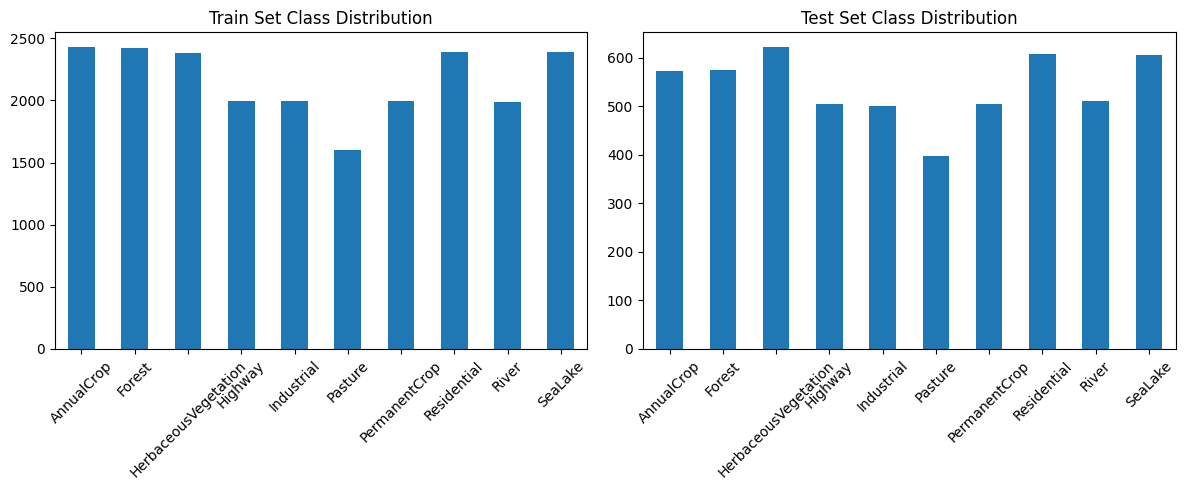


Visualizing training samples...


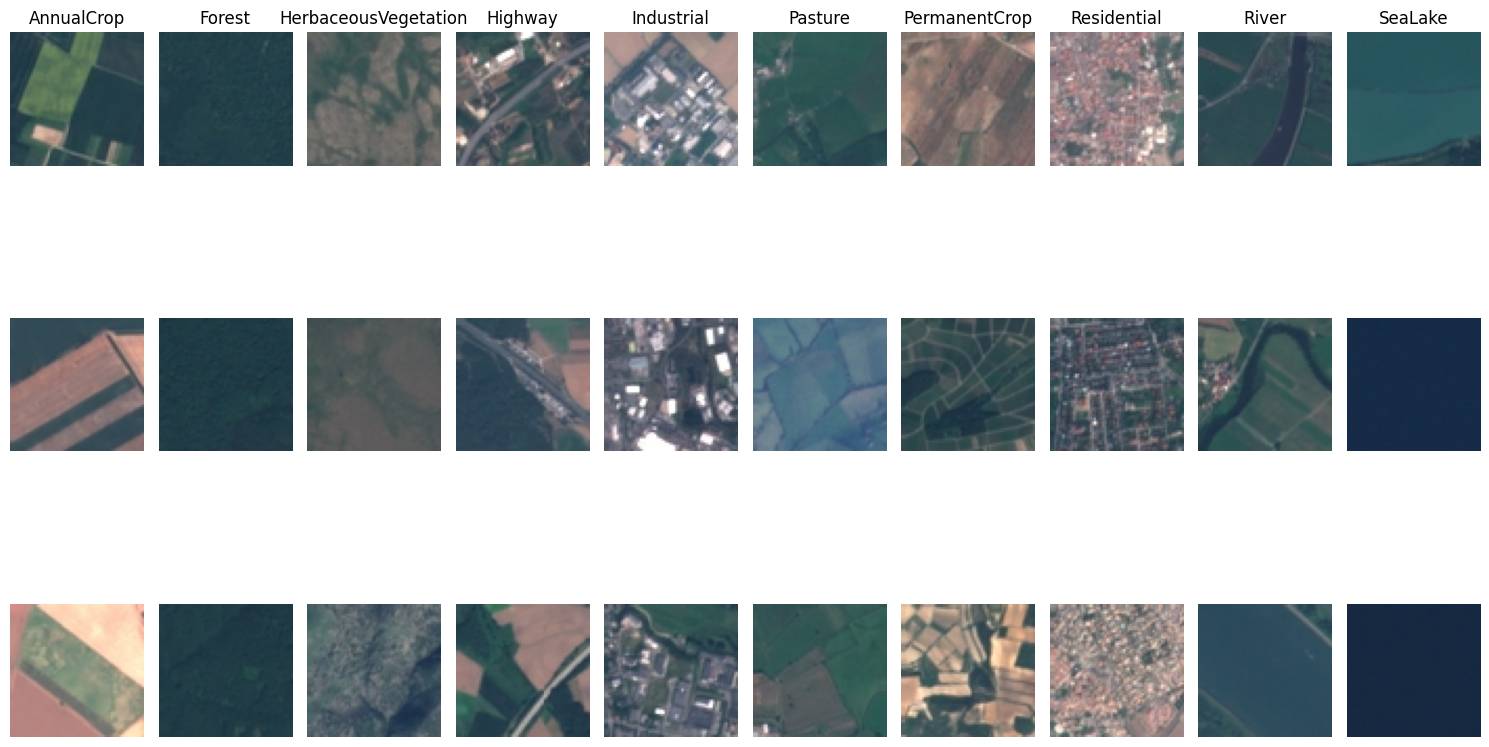


=== Pixel Statistics (Before Normalization) ===
Pixel range: 0 - 255
Mean pixel value: 95.5283
Std pixel value: 40.6717

=== Normalized Sample Stats ===
Min pixel value: 0.1020
Max pixel value: 0.3843
Mean: 0.2240


In [9]:
#=========== 1.Getting number of labels==============

class_names = ds_info.features['label'].names
num_classes = len(class_names)

# ========== 2. Convert tf.data.Dataset to NumPy ==========
train_images = []
train_labels = []
test_images = []
test_labels = []

for img, lbl in train_ds:
    train_images.append(img.numpy())
    train_labels.append(lbl.numpy())

for img, lbl in test_ds:
    test_images.append(img.numpy())
    test_labels.append(lbl.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# ========== 3. Dataset Summary ==========
print("\n=== Dataset Summary ===")
print(f"Total training samples: {len(train_images)}")
print(f"Total testing samples: {len(test_images)}")
print(f"Image shape: {train_images[0].shape}")  # Should be (64, 64, 3)
print(f"Number of classes: {num_classes}")

# ========== 4. Class Distribution Visualization ==========
plt.figure(figsize=(12, 5))

# Training set
plt.subplot(1, 2, 1)
pd.Series(train_labels).value_counts().sort_index().plot(kind='bar')
plt.title("Train Set Class Distribution")
plt.xticks(ticks=range(num_classes), labels=class_names, rotation=45)

# Testing set
plt.subplot(1, 2, 2)
pd.Series(test_labels).value_counts().sort_index().plot(kind='bar')
plt.title("Test Set Class Distribution")
plt.xticks(ticks=range(num_classes), labels=class_names, rotation=45)

plt.tight_layout()
plt.show()

# ========== 5. Sample Images per Class ==========
def plot_samples(images, labels, class_names, samples_per_class=3):
    plt.figure(figsize=(15, 10))
    for class_idx in range(num_classes):
        class_images = [img for img, lbl in zip(images, labels) if lbl == class_idx]
        for i in range(samples_per_class):
            plt_idx = i * num_classes + class_idx + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(class_images[i])
            if i == 0:
                plt.title(class_names[class_idx])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nVisualizing training samples...")
plot_samples(train_images, train_labels, class_names)

# ========== 6. Pixel Statistics ==========
print("\n=== Pixel Statistics (Before Normalization) ===")
print(f"Pixel range: {train_images.min()} - {train_images.max()}")
print(f"Mean pixel value: {np.mean(train_images):.4f}")
print(f"Std pixel value: {np.std(train_images):.4f}")

# ========== 7. Verify Normalization  ==========
# Normalize one batch for demonstration
train_ds_norm = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
for norm_images, _ in train_ds_norm.take(1):
    print("\n=== Normalized Sample Stats ===")
    print(f"Min pixel value: {tf.reduce_min(norm_images).numpy():.4f}")
    print(f"Max pixel value: {tf.reduce_max(norm_images).numpy():.4f}")
    print(f"Mean: {tf.reduce_mean(norm_images).numpy():.4f}")


## Preprocessing and Feature Engineering

In [10]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

train_ds = train_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

---

---

# Model Development and Optimization

In [11]:

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(200, activation='relu', ),
    layers.Dense(200, activation='relu', ),

    layers.Dense(10, activation='softmax')  # 10 classes
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


model.compile(
    optimizer=optimizer ,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Training

In [12]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 186s 272ms/step - accuracy: 0.3218 - loss: 1.7845 - val_accuracy: 0.5381 - val_loss: 1.1625
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 202s 272ms/step - accuracy: 0.5543 - loss: 1.1576 - val_accuracy: 0.6328 - val_loss: 0.9877
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 200s 269ms/step - accuracy: 0.6462 - loss: 0.9579 - val_accuracy: 0.6556 - val_loss: 0.9305
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 181s 269ms/step - accuracy: 0.6924 - loss: 0.8408 - val_accuracy: 0.6604 - val_loss: 0.9102
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 211s 283ms/step - accuracy: 0.7140 - loss: 0.7726 - val_accuracy: 0.6965 - val_loss: 0.8098
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 184s 273ms/step - accuracy: 0.7274 - loss: 0.7286 - val_accuracy: 0.7170 - val_loss: 0.7545
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 209s 284ms/step - accuracy: 0.7433 - loss: 0.6898 - val_accuracy: 0.7370 - val_loss: 0.7090
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 191s 283ms/step - accuracy: 0.7603 -

## Model Evaluation

In [14]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.7529 - loss: 0.6773
Test Accuracy: 75.06%
Test Loss: 0.6840


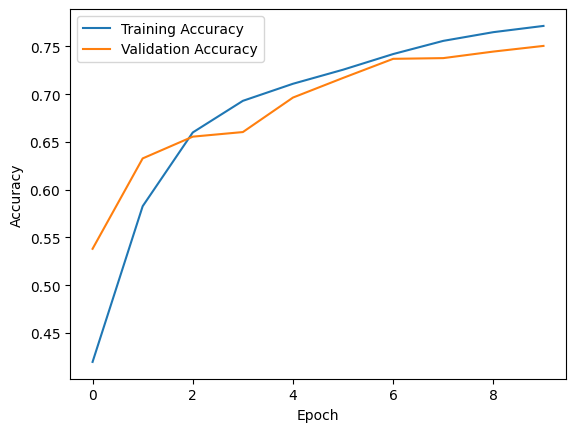

In [15]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


---

In [16]:
# Get true labels and predicted probabilities
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images, verbose=0))

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(y_true)

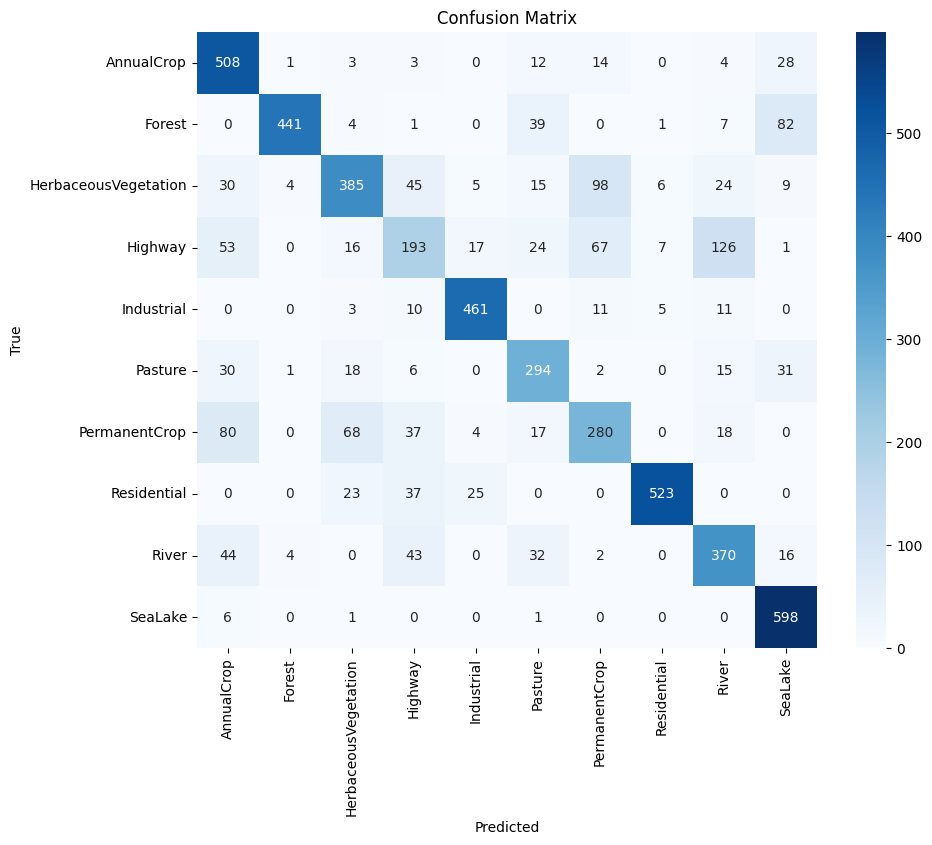

In [17]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

                      precision    recall  f1-score   support

          AnnualCrop       0.68      0.89      0.77       573
              Forest       0.98      0.77      0.86       575
HerbaceousVegetation       0.74      0.62      0.67       621
             Highway       0.51      0.38      0.44       504
          Industrial       0.90      0.92      0.91       501
             Pasture       0.68      0.74      0.71       397
       PermanentCrop       0.59      0.56      0.57       504
         Residential       0.96      0.86      0.91       608
               River       0.64      0.72      0.68       511
             SeaLake       0.78      0.99      0.87       606

            accuracy                           0.75      5400
           macro avg       0.75      0.74      0.74      5400
        weighted avg       0.75      0.75      0.75      5400



# visual prediction

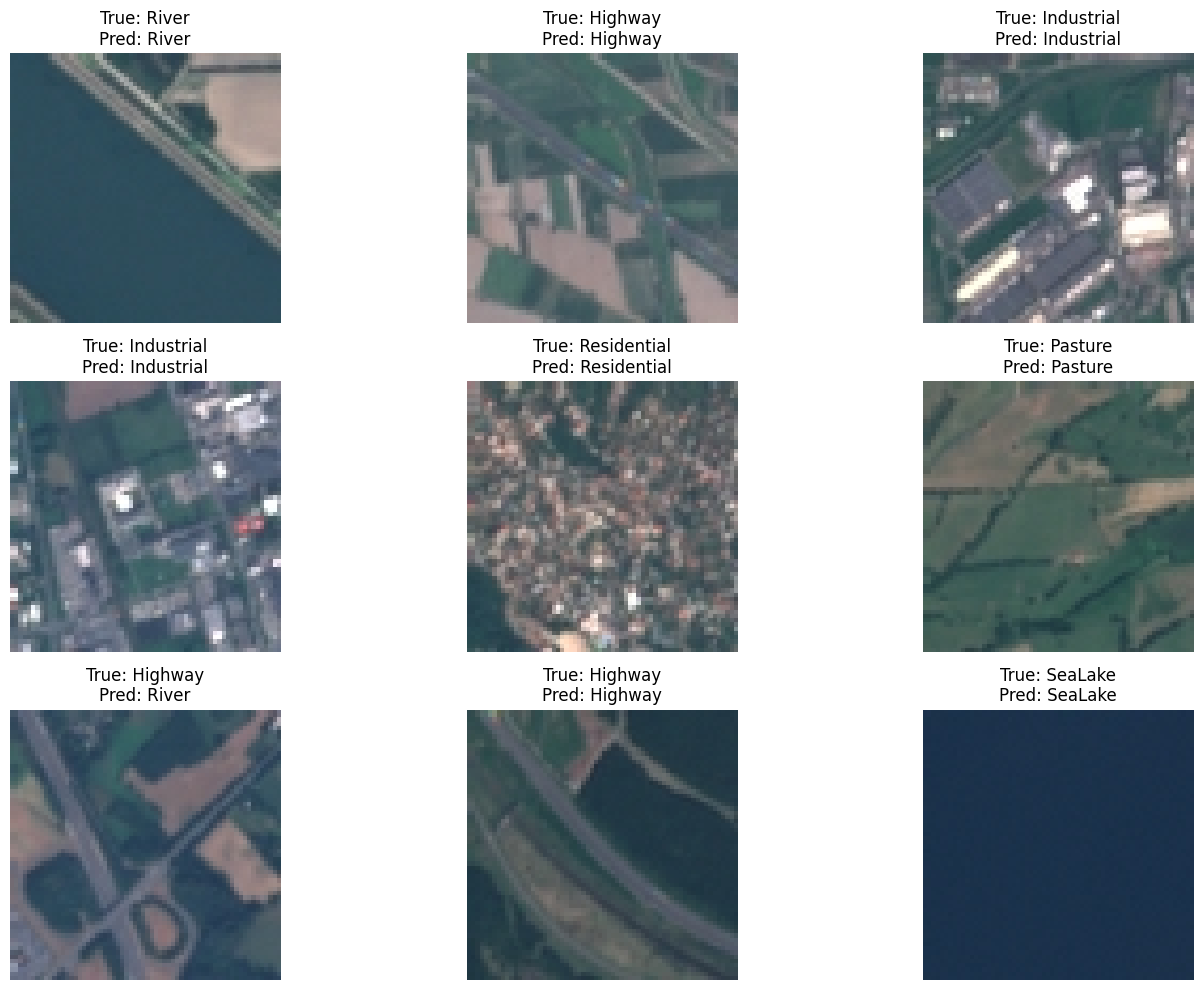

In [19]:
import random

# Convert test_ds to a list and shuffle it
test_images, test_labels = [], []
for img, lbl in test_ds.unbatch():  # Unbatch the dataset
    test_images.append(img.numpy())
    test_labels.append(lbl.numpy())

# Shuffle the data
combined = list(zip(test_images, test_labels))
random.shuffle(combined)
test_images_shuffled, test_labels_shuffled = zip(*combined)

# Select 9 random samples
num_samples = 9
random_indices = random.sample(range(len(test_images_shuffled)), num_samples)

# Plot the random samples with predictions
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    image = test_images_shuffled[idx]
    true_label = test_labels_shuffled[idx]

    # Predict (add batch dimension with np.expand_dims)
    pred_prob = model.predict(np.expand_dims(image, axis=0), verbose=0)
    pred_label = np.argmax(pred_prob, axis=1)[0]

    # Plot
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)  # Assumes RGB (if using 'eurosat/rgb')
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Model Improvment

In [21]:
# Model 1 with more number of epochs
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(200, activation='relu', ),
    layers.Dense(200, activation='relu', ),

    layers.Dense(10, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


model1.compile(
    optimizer=optimizer ,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
history1 = model1.fit(train_ds, epochs=25, validation_data=test_ds)

Epoch 1/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 243s 356ms/step - accuracy: 0.3254 - loss: 1.7188 - val_accuracy: 0.5296 - val_loss: 1.1540
Epoch 2/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 183s 271ms/step - accuracy: 0.5491 - loss: 1.1403 - val_accuracy: 0.6115 - val_loss: 1.0290
Epoch 3/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 200s 269ms/step - accuracy: 0.6573 - loss: 0.9392 - val_accuracy: 0.6387 - val_loss: 0.9877
Epoch 4/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 190s 282ms/step - accuracy: 0.7076 - loss: 0.8018 - val_accuracy: 0.6904 - val_loss: 0.8363
Epoch 5/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 190s 281ms/step - accuracy: 0.7282 - loss: 0.7413 - val_accuracy: 0.7157 - val_loss: 0.7622
Epoch 6/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 202s 281ms/step - accuracy: 0.7439 - loss: 0.6964 - val_accuracy: 0.7472 - val_loss: 0.6749
Epoch 7/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 203s 283ms/step - accuracy: 0.7576 - loss: 0.6595 - val_accuracy: 0.7707 - val_loss: 0.6239
Epoch 8/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 192s 268ms/step - accuracy: 0.7692 -

In [24]:
test_loss1, test_acc1 = model1.evaluate(test_ds)
print(f"Test Accuracy: {test_acc1 * 100:.2f}%")
print(f"Test Loss: {test_loss1:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.8487 - loss: 0.4094
Test Accuracy: 84.81%
Test Loss: 0.4151


## After 15 epochs val_ accuracy is less than training accuracy which considered as indication of 15 epochs is a good number .

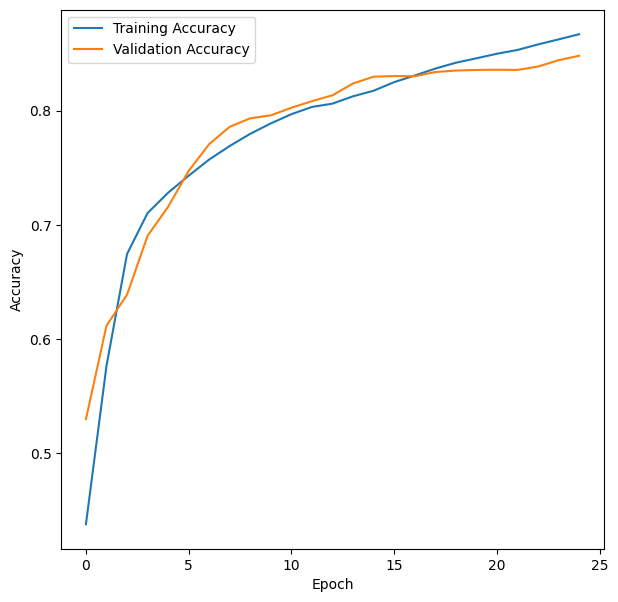

In [28]:
# Plot training history
plt.figure(figsize=(7, 7))
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


---

In [29]:
# Get true labels and predicted probabilities
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model1.predict(images, verbose=0))

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(y_true)

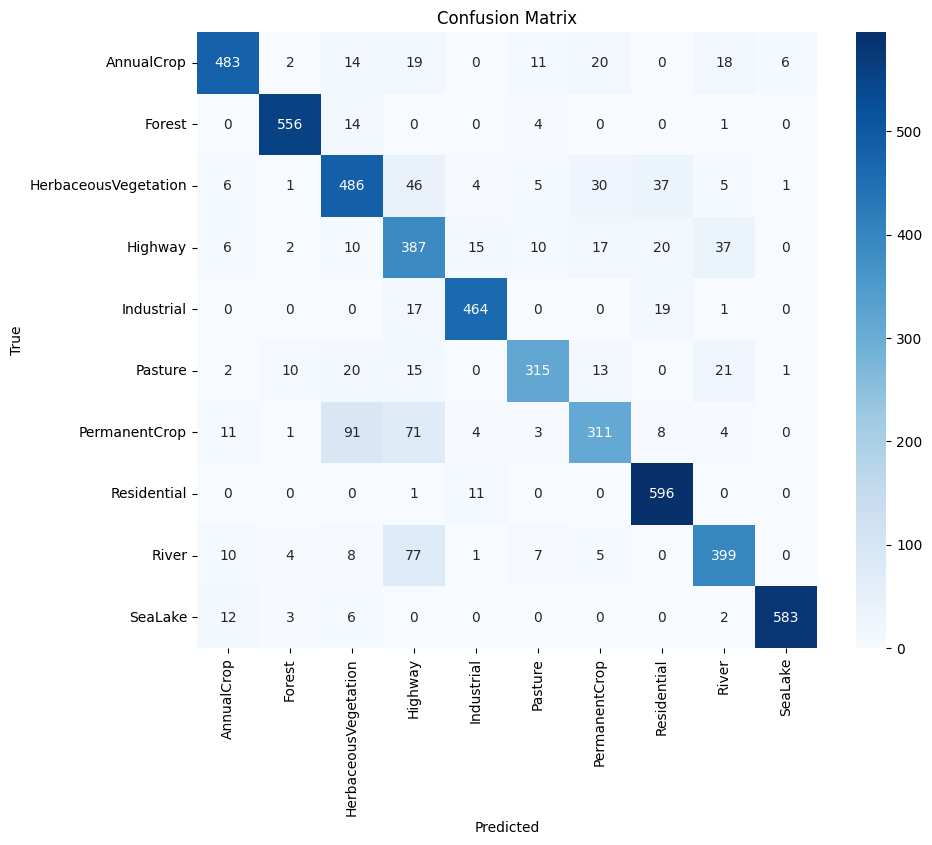

In [30]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
#  classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.84      0.88       573
              Forest       0.96      0.97      0.96       575
HerbaceousVegetation       0.75      0.78      0.77       621
             Highway       0.61      0.77      0.68       504
          Industrial       0.93      0.93      0.93       501
             Pasture       0.89      0.79      0.84       397
       PermanentCrop       0.79      0.62      0.69       504
         Residential       0.88      0.98      0.93       608
               River       0.82      0.78      0.80       511
             SeaLake       0.99      0.96      0.97       606

            accuracy                           0.85      5400
           macro avg       0.85      0.84      0.84      5400
        weighted avg       0.85      0.85      0.85      5400



### Hyperparameter Tuning

In [67]:
# Model 2 with Adding some layers

model2 = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3),padding='same',strides=1),

    layers.Conv2D(64, (3, 3), activation='relu',padding='same',strides=1),

    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu',padding='same',strides=1),
    layers.Conv2D(32, (3, 3), activation='relu',padding='same',strides=1),

    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(250, activation='relu', ),

    # layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=1000,      # Reduce LR every 1000 steps
    decay_rate=0.9,
    staircase=True         # Discretize decay
)

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss='sparse_categorical_crossentropy',metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# using 15 epochs
history2 = model2.fit(train_ds, epochs=15, validation_data=test_ds)

Epoch 1/15
568/675 ━━━━━━━━━━━━━━━━━━━━ 2:00 1s/step - accuracy: 0.1145 - loss: 2.8339

In [ ]:

# Get true labels and predicted probabilities
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images, verbose=0))

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(y_true)

In [ ]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

print(classification_report(y_true, y_pred, target_names=class_names))

# Milestone 4: Deployment and Monitoring

## Deployment
- Saved model for production use
- Created FastAPI endpoint for predictions

In [ ]:
# Save model
model.save('land_classifier.h5')

# Example FastAPI app (would be in separate file)
'''
from fastapi import FastAPI
from tensorflow.keras.models import load_model
import numpy as np

app = FastAPI()
model = load_model('land_classifier.h5')

@app.post("/predict")
def predict(data: dict):
    image = preprocess_input(data["image"])
    pred = model.predict(image)
    land_type = le.inverse_transform([np.argmax(pred)])
    return {"land_type": land_type[0], "confidence": float(np.max(pred))}
'''

---